In [1]:

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
import os
from langchain_groq import ChatGroq
os.environ['OPENAI_API_KEY']=os.getenv('OPENAI_API_KEY')
os.environ['GROQ_API_KEY']=os.getenv('GROQ_API_KEY')
os.environ['LANGSMITH,_API_KEY']=os.getenv('LANGCHAIN_API_KEY')

llm = ChatGroq(model="qwen/qwen3-32b")
response=llm.invoke("Hello")
response.content

/home/maniram/workspace/python/langchain-projects/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


'<think>\nOkay, the user just said "Hello". I need to respond appropriately. Let me start by greeting them back in a friendly manner. Maybe ask how I can assist them today. Keep it open-ended so they can specify their needs. Make sure the tone is welcoming and helpful.\n</think>\n\nHello! How can I assist you today? 😊'

In [3]:
from typing import Annotated,List
from typing_extensions import Literal
import operator
from pydantic import BaseModel,Field
from langchain_core.messages import HumanMessage,SystemMessage
from typing_extensions import TypedDict

#Graph State

class State(TypedDict):
    joke:str
    topic:str
    feedback:str
    funny_or_not:str
    

In [4]:
class Feedback(BaseModel):
    grade:Literal["funny","not funny"] = Field(description="Decide if the joke is funny or not")
    feedback:str=Field(description="If the joke is funny, provide feedback on how to improve it.")

# Augment the LLM with schema for structured output
evaluator=llm.with_structured_output(Feedback)

In [ ]:
# Nodes

def llm_call_generator(state:State):
    """LLM generate a joke"""
    if state.get("feedback"):
        msg=llm.invoke(f"Write a joke about {state['topic']} but take action into account the feedback : {state['feedback']}")
    else:
        msg=llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke":msg.content}

def llm_call_evaluator(state:State):
    """LLM evaluate the joke"""
    grade = evaluator.invoke(f"Grade the joke {state['joke']}")
    return {"funny_or_not":grade.grade,"feedback":grade.feedback}


def route_joke(state:State):
    """Route back to joke generate or end based upon feedback from the evaluator"""
    if state["funny_or_not"]=="funny":
        return "Accepted"
    elif state["funny_or_not"]=="not funny":
        return "Rejected + Feedback"
    


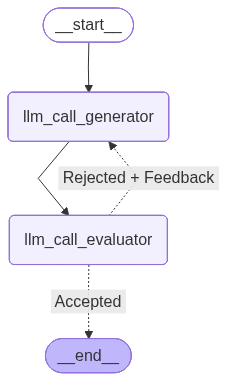

In [10]:
from langgraph.graph import StateGraph,START,END
from IPython.display import Image,display

# buil a graph
optimizer_builder=StateGraph(State)
optimizer_builder.add_node("llm_call_generator",llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator",llm_call_evaluator)


optimizer_builder.add_edge(START,"llm_call_generator")
optimizer_builder.add_edge("llm_call_generator","llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {
        "Accepted":END,
        "Rejected + Feedback":"llm_call_generator"
    }   ) 

# compile the graph
optimizer_worker = optimizer_builder.compile()

#Visualize thegraph 
graph_image=optimizer_worker.get_graph().draw_mermaid_png()
display(Image(graph_image))

In [11]:
#run the graph
from IPython.display import Markdown
state={"topic":"cat"}
result=optimizer_worker.invoke(state)
result


{'joke': '<think>\nOkay, I need to come up with a joke about a cat. Let me think... Cats are known for their independence, their playful nature, and maybe some funny habits like knocking things off tables or obsession with boxes. Maybe I can play on some of these traits.\n\nFirst, what\'s a common stereotype about cats? They\'re often called lazy because they sleep a lot. Or maybe their aloofness compared to dogs. Maybe a play on words? Like "paw-some" instead of "awesome"? Or something about them being "fishing" if they\'re knocking things off the table.\n\nWait, there\'s also the meme about cats sitting on laptops or phones. Maybe combine that with their indifference. Like why did the cat sit on the laptop? To get a better "paw-view"? That\'s a classic pun structure. Let me test that:\n\nWhy did the cat sit on the keyboard? To type a letter to the mouse union. Hmm, not bad, but maybe not the best. Or maybe why did the cat sit on the laptop? For a better "paw-view". That\'s a bit bett